In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
np.random.seed(42)

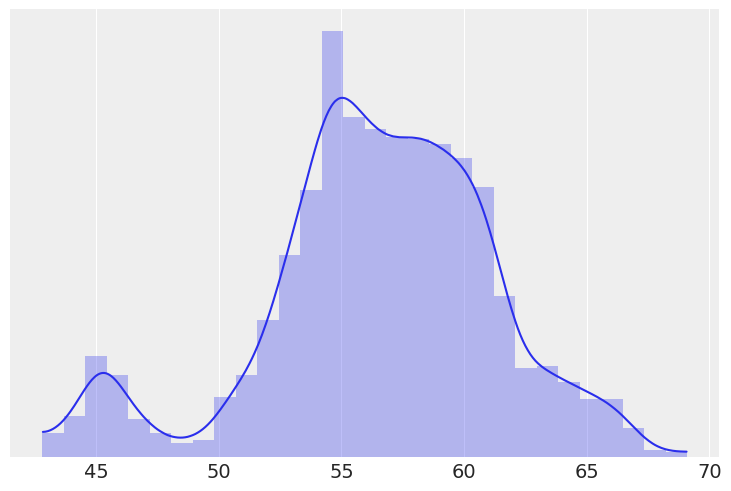

In [4]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])
plt.savefig('B11197_06_02.png')

In [5]:
#with pm.Model() as model_kg:
#    p = pm.Dirichlet('p', a=np.ones(clusters))
#    z = pm.Categorical('z', p=p, shape=len(cs_exp))
#    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
#    sd = pm.HalfNormal('sd', sd=10)
#
#    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
#    idata_kg = pm.sample(return_inferencedata=True)

In [6]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


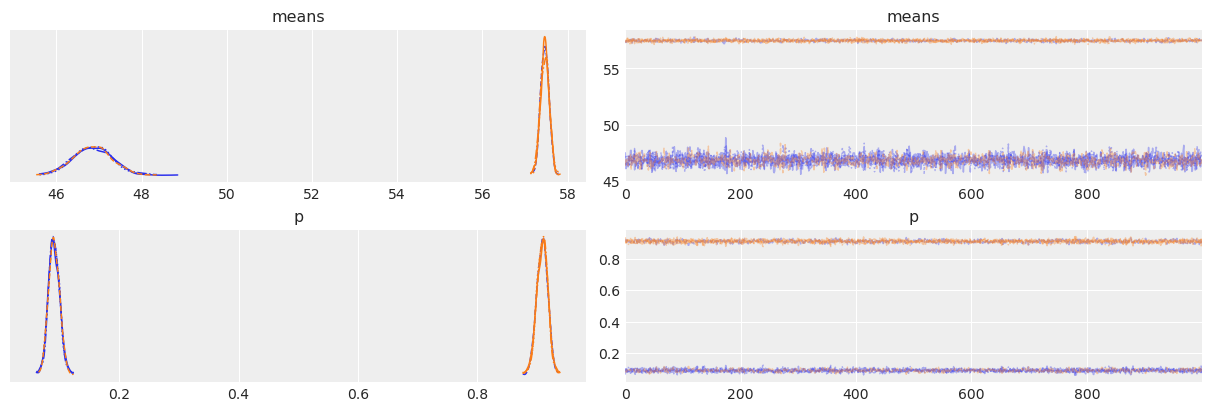

In [7]:
varnames = ['means', 'p']
az.plot_trace(idata_mg, varnames)
plt.savefig('B11197_06_06.png')

In [8]:
az.summary(idata_mg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],49.505,4.613,46.192,57.631,2.290,1.753,7.0,30.0,1.53
means[1],54.810,4.608,46.508,57.707,2.292,1.755,7.0,29.0,1.53
p[0],0.295,0.355,0.075,0.921,0.177,0.135,7.0,30.0,1.53
p[1],0.705,0.355,0.079,0.925,0.177,0.135,7.0,30.0,1.53


## Non-identifiability of mixture models

In [9]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(),
                      sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means',
                               tt.switch(means[1]-means[0] < 0,
                                         -np.inf, 0))
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    idata_mgp = pm.sample(1000, random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [10]:
# instead of a potential we can use an ordered transformation
# transform=pm.distributions.transforms.ordered

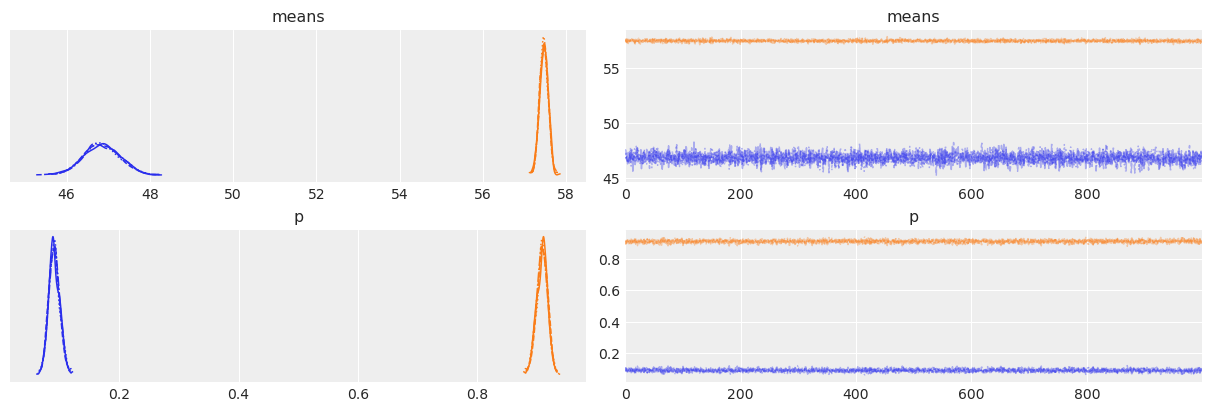

In [11]:
varnames = ['means', 'p']
az.plot_trace(idata_mgp, varnames)
plt.savefig('B11197_06_07.png')

In [12]:
az.summary(idata_mgp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],46.842,0.434,46.070,47.689,0.007,0.005,3522.0,3550.0,1.0
means[1],57.466,0.101,57.275,57.650,0.002,0.001,4237.0,3135.0,1.0
p[0],0.091,0.009,0.074,0.109,0.000,0.000,3337.0,3099.0,1.0
p[1],0.909,0.009,0.891,0.926,0.000,0.000,3337.0,3099.0,1.0
sd,3.651,0.075,3.512,3.797,0.001,0.001,3819.0,2886.0,1.0


## How to choose K

In [13]:
clusters = [3, 4, 5, 6]

models = []
idatas = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
                          sd=10, shape=cluster,
                          transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        idata = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=123, return_inferencedata=True)
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 66 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 157 seconds.
There were 734 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10745848810095399, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9714571095715772, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


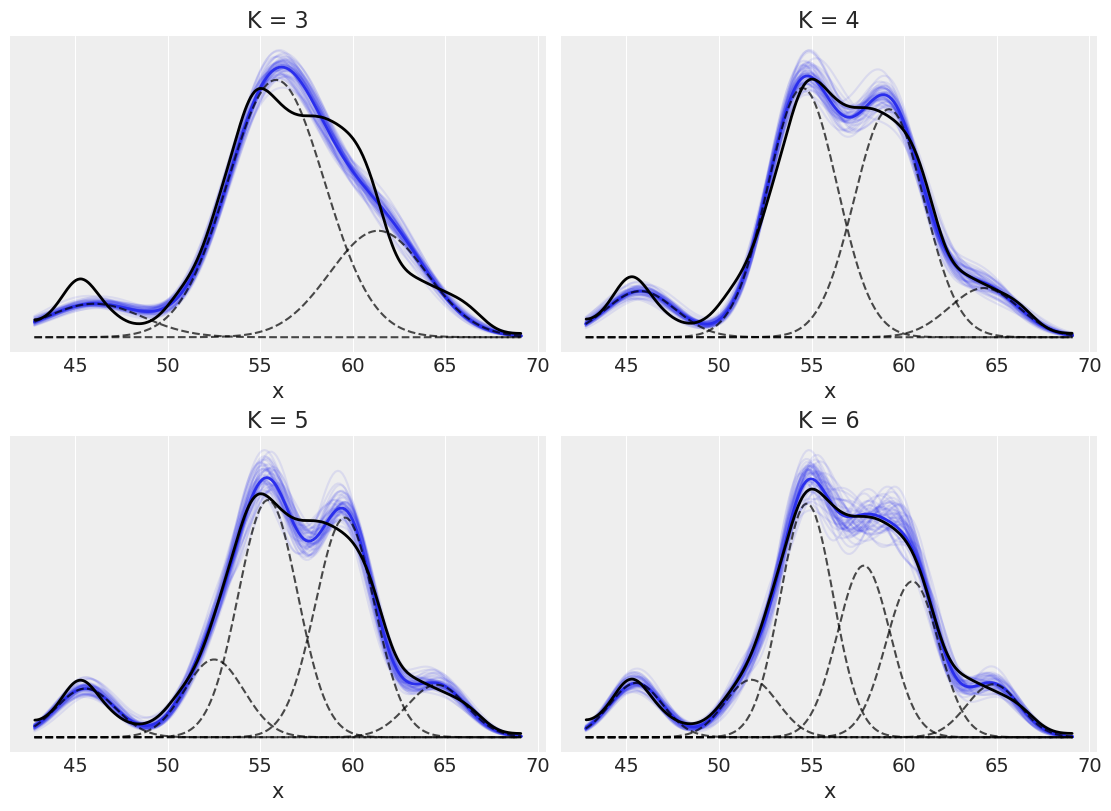

In [14]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = np.random.randint(0, posterior_x.samples.size)
        means_y = posterior_x['means'][:,i_]
        p_y = posterior_x['p'][:,i_]
        sd = posterior_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', alpha=0.1)
 
    means_y = posterior_x['means'].mean("samples")
    p_y = posterior_x['p'].mean("samples")
    sd = posterior_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')
plt.savefig('B11197_06_08.png')

In [15]:
ppc_mm = [pm.sample_posterior_predictive(idatas[i], 1000, models[i])
          for i in range(4)]

/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


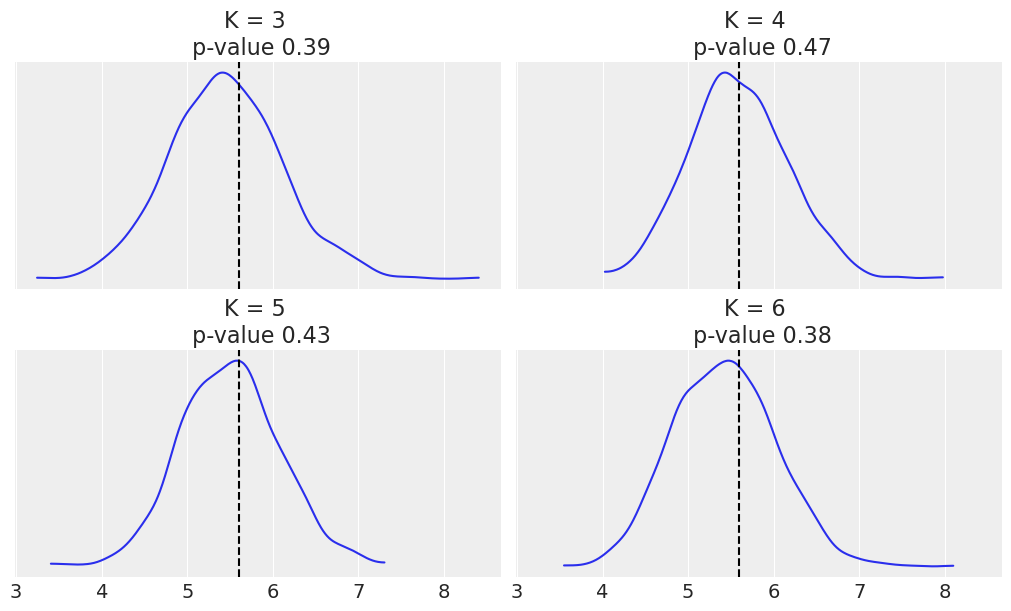

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])
plt.savefig('B11197_06_09.png')

In [17]:
comp = az.compare(dict(zip([str(c) for c in clusters], idatas)),
                  method='BB-pseudo-BMA', ic="waic", scale="deviance")
comp

/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6,0,10247.314958,11.148728,0.000000,9.572300e-01,63.234324,0.000000,False,deviance
5,1,10258.073951,9.715544,10.758993,4.195516e-02,61.319559,4.886116,False,deviance
4,2,10279.111075,7.547602,31.796118,8.148386e-04,60.648322,9.708157,False,deviance
3,3,10356.949722,5.974573,109.634764,5.723423e-14,60.412837,18.009105,False,deviance


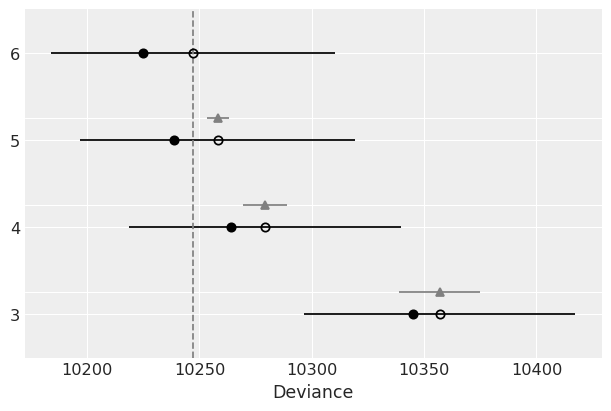

In [18]:
az.plot_compare(comp)
plt.savefig('B11197_06_10.png')

## Non-finite mixture model

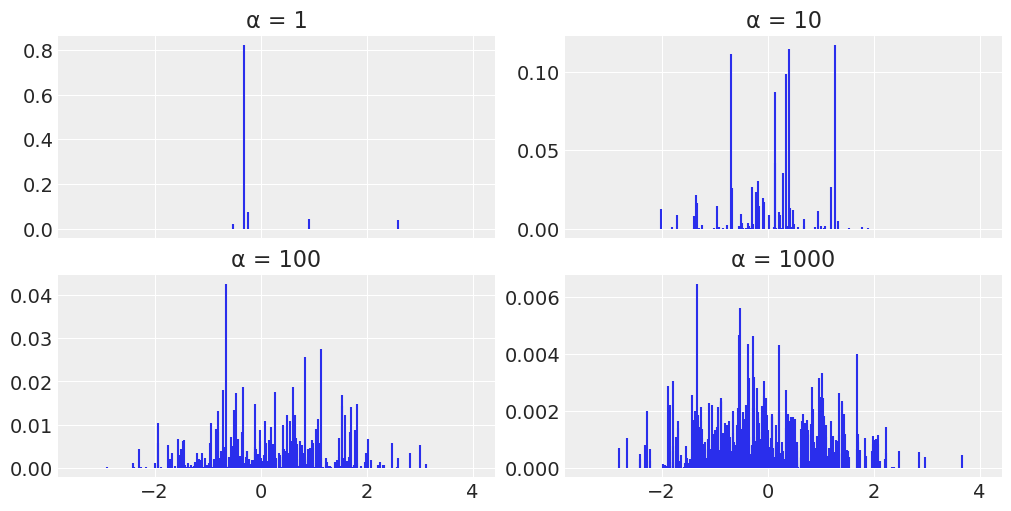

In [19]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : scipy distribution
        Base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))

plt.savefig('B11197_06_11.png')

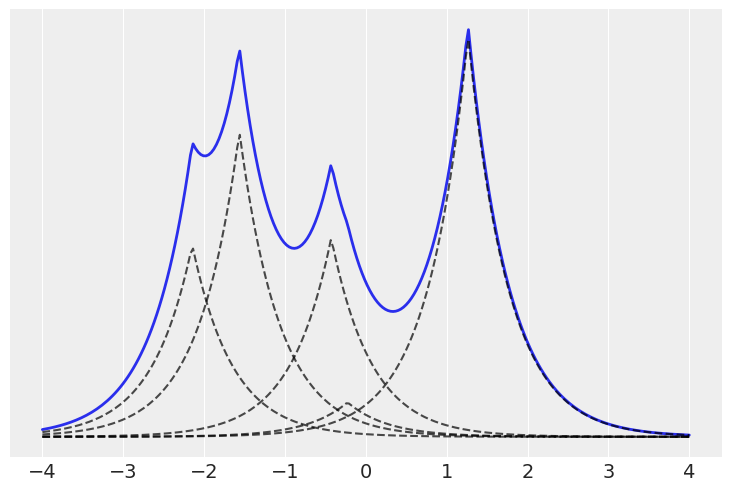

In [20]:
α = 10
H = stats.norm
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])
plt.savefig('B11197_06_12.png')

In [21]:
K = 20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [22]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sd=10, shape=K)
    
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    idata = pm.sample(1000, tune=2000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]


/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/u/32/martino5/unix/anaconda3/envs/pymcv3/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 410 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8348488516139099, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat 

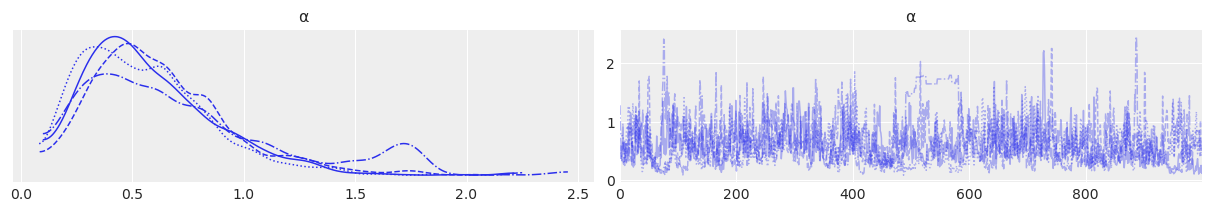

In [23]:
az.plot_trace(idata, var_names=['α'], divergences=False);
plt.savefig('B11197_06_13.png')

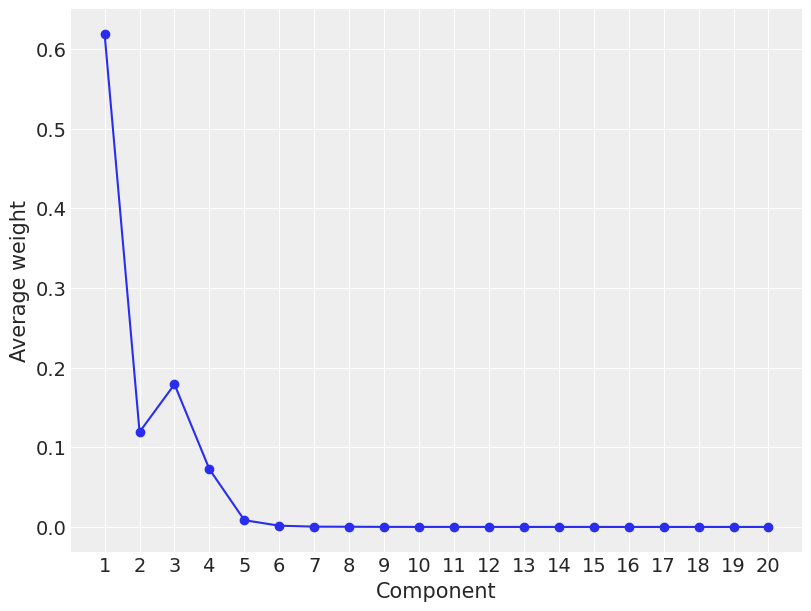

In [24]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, idata.posterior['w'].mean(("chain", "draw")), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')
plt.savefig('B11197_06_14.png')

In [39]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

posterior = idata.posterior.stack(samples=("chain", "draw"))

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   posterior['means'].values[:, np.newaxis, :],
                                   posterior['sd'].values[:, np.newaxis, :])
post_pdfs = (posterior['w'].values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=0)

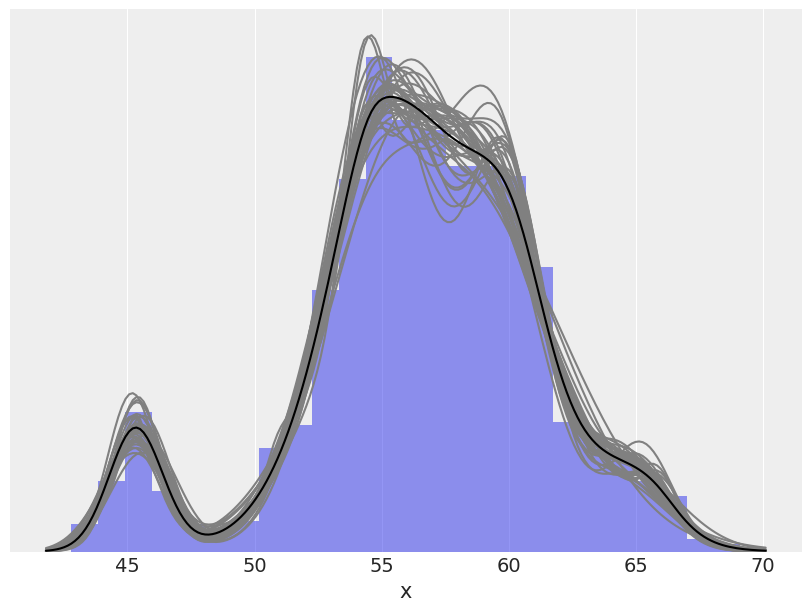

In [68]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[:,::100], c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=1), c='k')

plt.xlabel('x')
plt.yticks([])
plt.savefig('B11197_06_15.png')

In [27]:
## Exercises
#clusters = 3
#n_cluster = [200, 150, 170]
#n_total = sum(n_cluster)
#means = [5, 0, -3]
#std_devs = [2, 2, 2]
#mix = np.random.normal(np.repeat(means, n_cluster),
#np.repeat(std_devs, n_cluster))
#az.plot_kde(np.array(mix));